In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl
import cbmos.utils as ut

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 7.5  # final time
rA = 1.5   # maximum interaction distance
dim = 3
seed=67

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

# Global adaptive time-stepping for a globally compressed monolayer

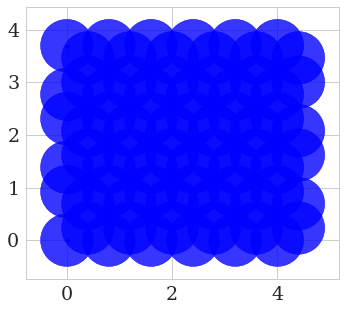

In [4]:
coords = ut.generate_hcp_coordinates(6,6,6, scaling=0.8)

sheet = [cl.Cell(i, [x,y,z]) for i, (x,y,z) in enumerate(coords)]

ut.plot_2d_population(sheet)

Initial step cubic 0.035638729191715124
Stability bound estimate cubic 0.05371102788151523
Initial step cubic 0.035638729191715124
Stability bound estimate cubic 0.05371102788151523
Initial step cubic 0.03201113080084213
Stability bound estimate cubic 0.057855726026748135


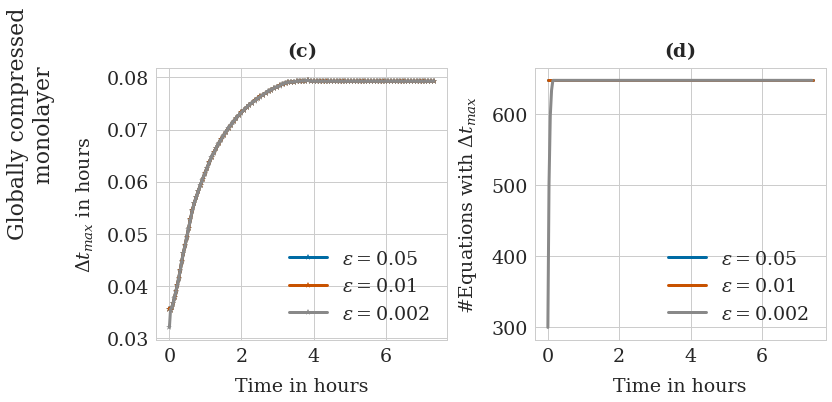

In [5]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace':0.2, 'wspace': 0.3})
#fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})


force = 'cubic'
epsilons = [0.05, 0.01, 0.002]

for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    try:
        os.remove('n_eq_per_level'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')

    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True,'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'local_adaptivity': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ax1.plot(ts[:-2], dts[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i])
    
    n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
    ax2.plot(ts[:-1], n_eq_per_level[2,:], label='$\epsilon=$'+str(eps), color=colors[i])

ax1.set_title(r'$\bf{(c)}$')
ax1.legend()
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t_{max}$ in hours')
ax1.text(-4.5, 0.05, 'Globally compressed\n        monolayer', fontsize=22, rotation='vertical')



#ax1.set(ylim=[-0.01, 0.18])
#ax2.text(3.4, 1.45, '$\epsilon=0.001$', fontsize=22)

ax2.legend()
ax2.set(xlabel='Time in hours')
ax2.set(ylabel='#Equations with $\Delta t_{max}$')
ax2.set_title(r'$\bf{(d)}$')


plt.savefig('local_adap_glob_mono.pdf', bbox_inches='tight')